In [1]:
'''
Diffuse the latent space of VAE model to random noise;
Apply to Gaussian samples as an example.
'''

'\nDiffuse the latent space of VAE model to random noise;\nApply to Gaussian samples as an example.\n'

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *

In [3]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
sample_dim = 6
batch_size = 40
sample_size = 400
rho = 0.9
num_epochs = 60
learning_rate = 1e-3
z_dim = 10
sample_dir = './results/samples'
lamd = 10

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
data = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = sample_size, to_cuda = False)

In [5]:
dataLoader = torch.utils.data.DataLoader(GetLoader(data), batch_size=40, shuffle=True, drop_last=False, num_workers=2)

Epoch[1/60], Step [400/400], Reconst Loss: 1.0642, KL Div: 8.1283
Epoch[2/60], Step [400/400], Reconst Loss: 1.1130, KL Div: 3.4735
Epoch[3/60], Step [400/400], Reconst Loss: 1.0169, KL Div: 2.0712
Epoch[4/60], Step [400/400], Reconst Loss: 1.0126, KL Div: 1.5666
Epoch[5/60], Step [400/400], Reconst Loss: 1.0015, KL Div: 1.3773
Epoch[6/60], Step [400/400], Reconst Loss: 1.0152, KL Div: 1.1255
Epoch[7/60], Step [400/400], Reconst Loss: 1.0145, KL Div: 1.0425
Epoch[8/60], Step [400/400], Reconst Loss: 0.9926, KL Div: 0.8028
Epoch[9/60], Step [400/400], Reconst Loss: 1.1073, KL Div: 0.7275
Epoch[10/60], Step [400/400], Reconst Loss: 0.8231, KL Div: 0.5559
Epoch[11/60], Step [400/400], Reconst Loss: 0.9632, KL Div: 0.5421


/home/wangxu/Documents/projects/LSGM-demo/utils.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(d, d, figsize=(8,8), sharex=True, sharey=True)


Epoch[12/60], Step [400/400], Reconst Loss: 1.0235, KL Div: 0.5336
Epoch[13/60], Step [400/400], Reconst Loss: 1.1165, KL Div: 0.4769
Epoch[14/60], Step [400/400], Reconst Loss: 1.0707, KL Div: 0.4287
Epoch[15/60], Step [400/400], Reconst Loss: 0.9353, KL Div: 0.4168
Epoch[16/60], Step [400/400], Reconst Loss: 0.9728, KL Div: 0.3445
Epoch[17/60], Step [400/400], Reconst Loss: 0.9780, KL Div: 0.3622
Epoch[18/60], Step [400/400], Reconst Loss: 1.0261, KL Div: 0.3264
Epoch[19/60], Step [400/400], Reconst Loss: 0.8779, KL Div: 0.3355
Epoch[20/60], Step [400/400], Reconst Loss: 1.0641, KL Div: 0.2870
Epoch[21/60], Step [400/400], Reconst Loss: 1.0404, KL Div: 0.3085
Epoch[22/60], Step [400/400], Reconst Loss: 0.8845, KL Div: 0.2457
Epoch[23/60], Step [400/400], Reconst Loss: 1.1147, KL Div: 0.2593
Epoch[24/60], Step [400/400], Reconst Loss: 1.0395, KL Div: 0.2216
Epoch[25/60], Step [400/400], Reconst Loss: 0.9355, KL Div: 0.2101
Epoch[26/60], Step [400/400], Reconst Loss: 0.8986, KL Div: 0.

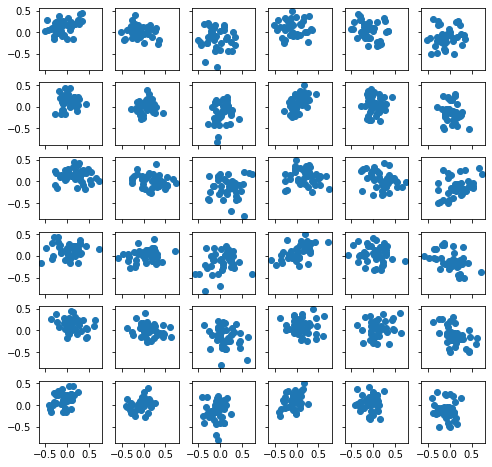

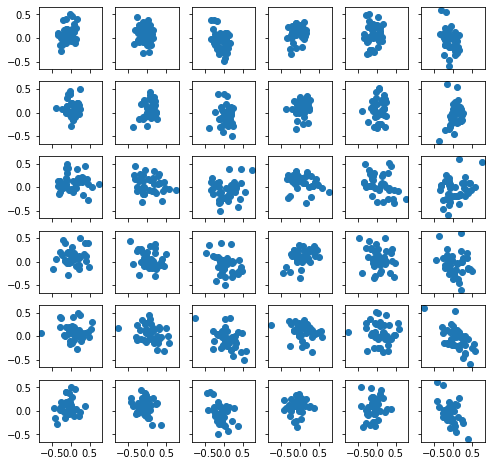

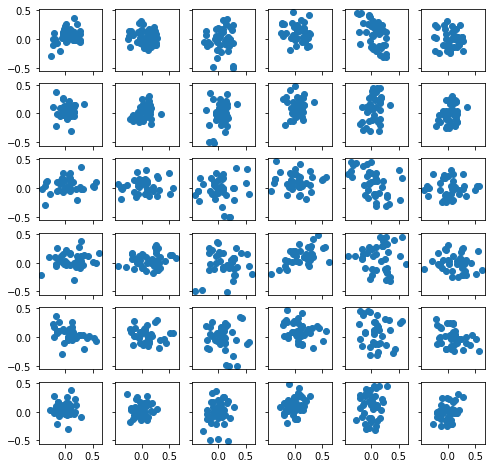

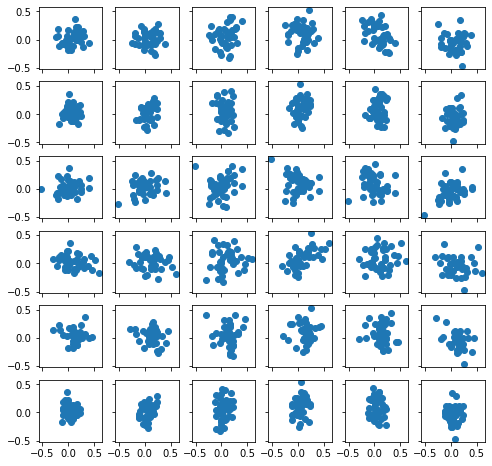

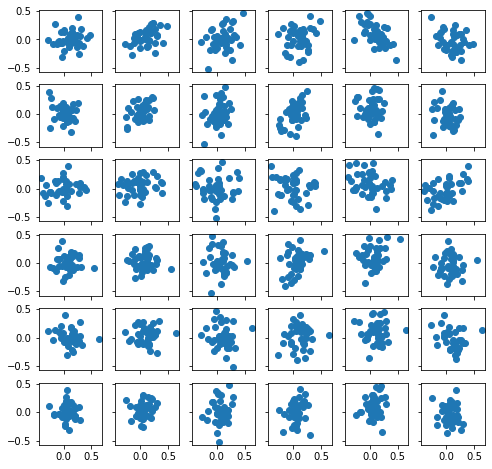

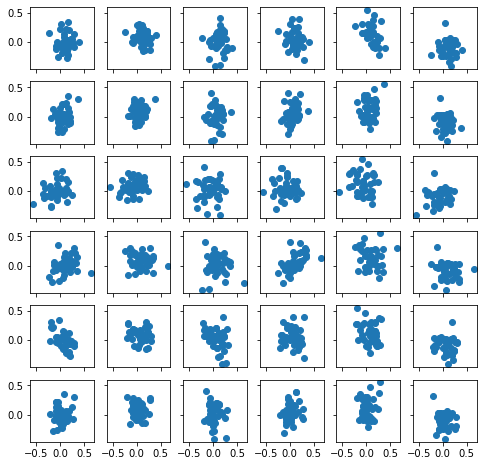

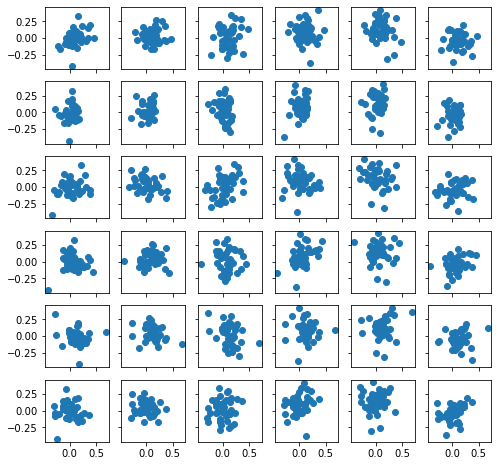

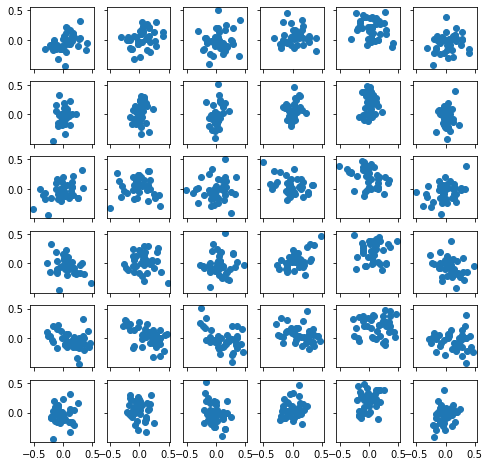

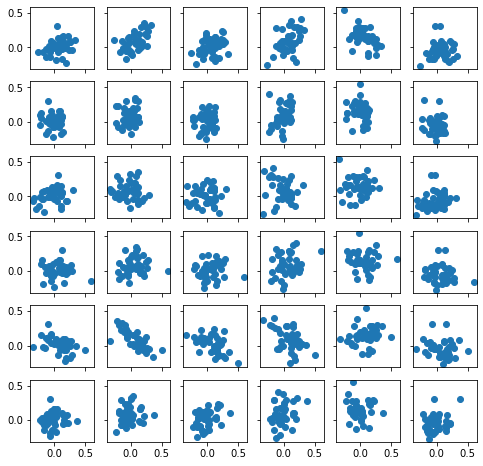

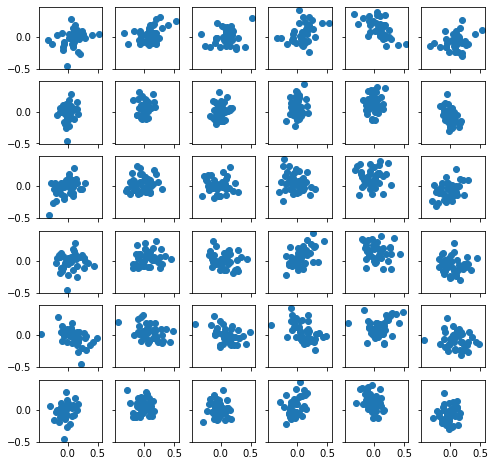

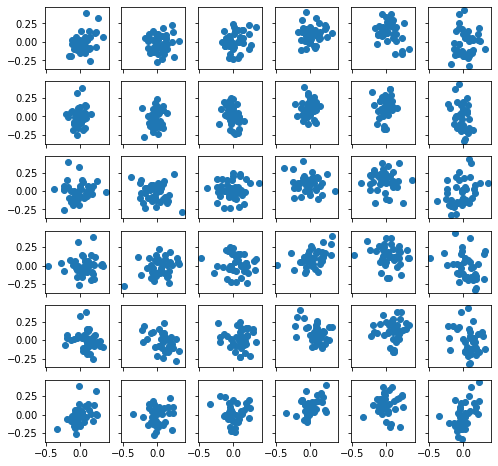

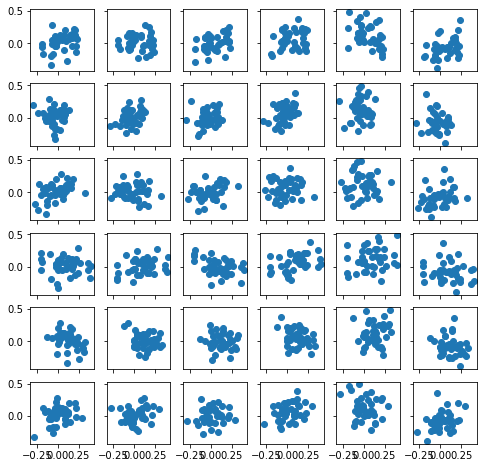

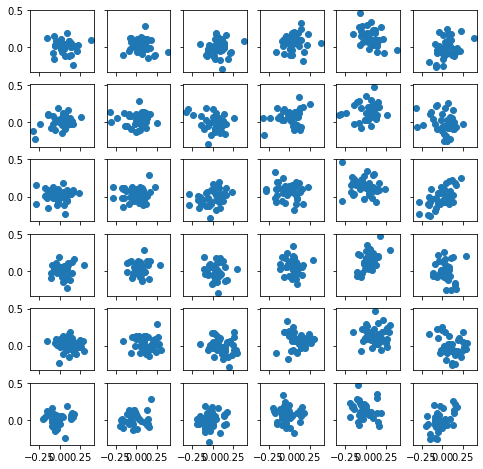

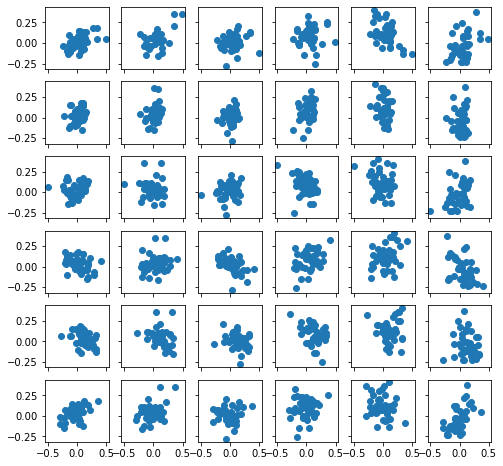

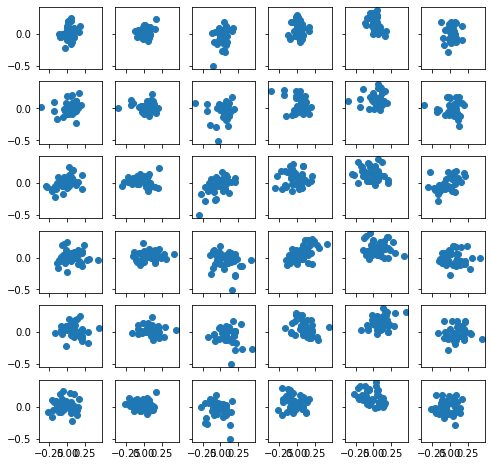

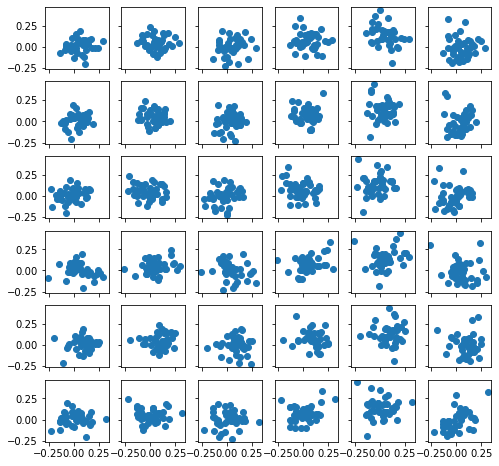

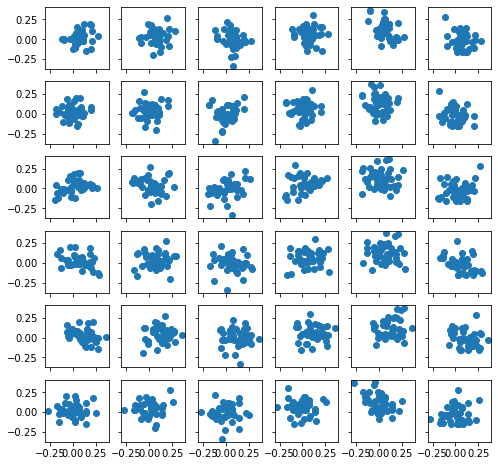

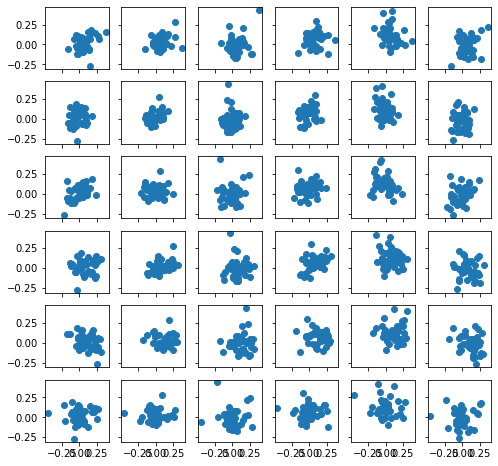

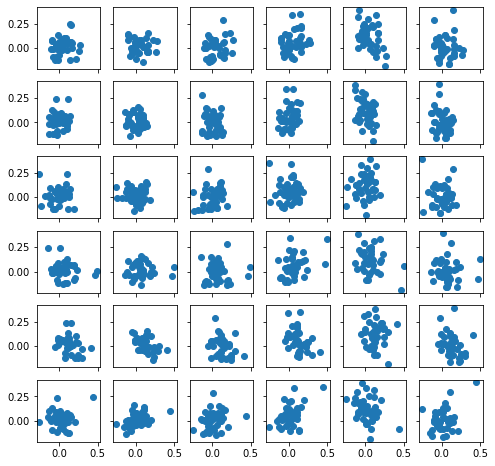

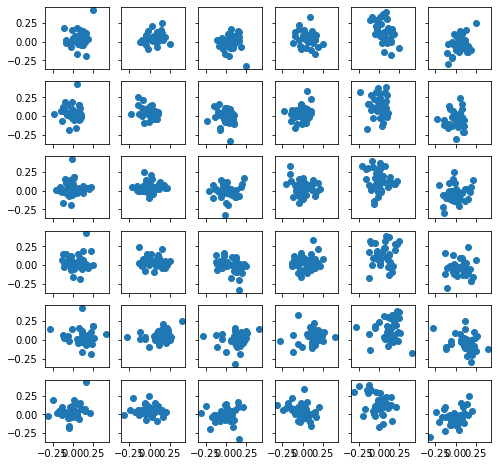

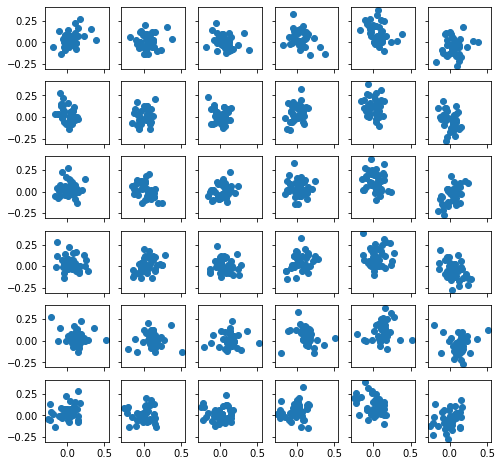

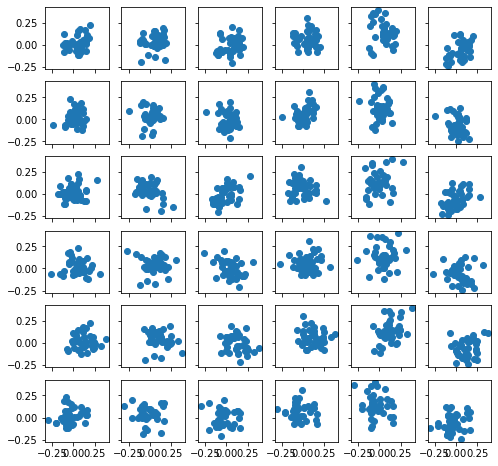

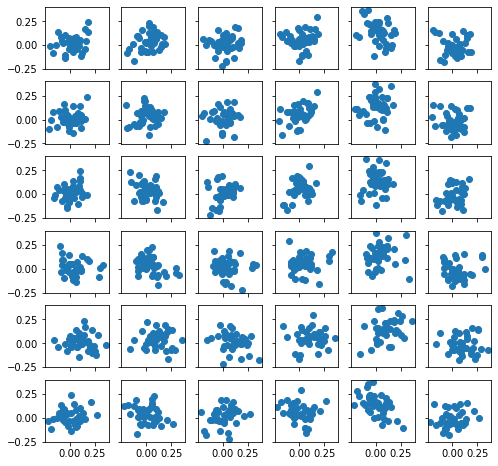

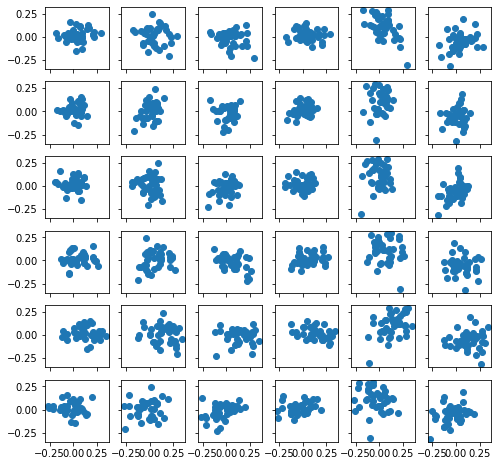

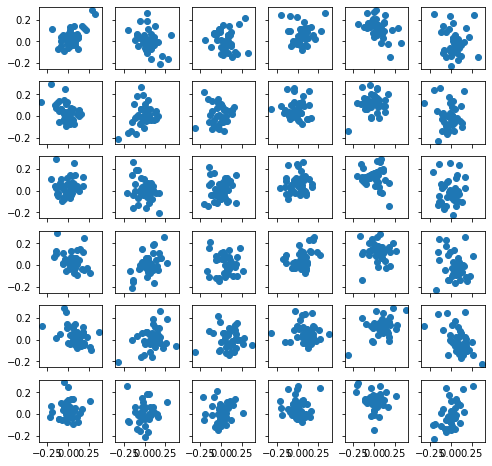

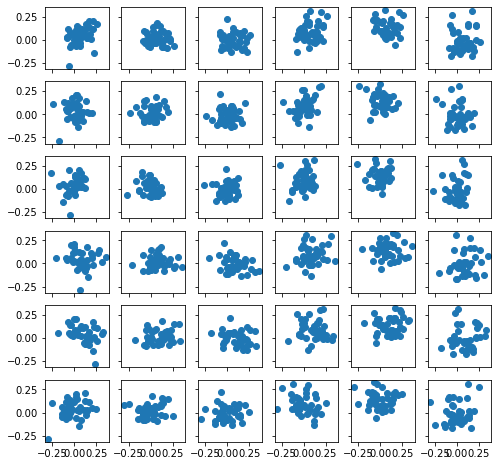

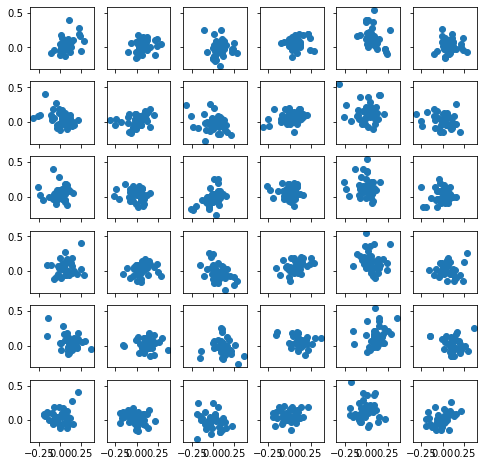

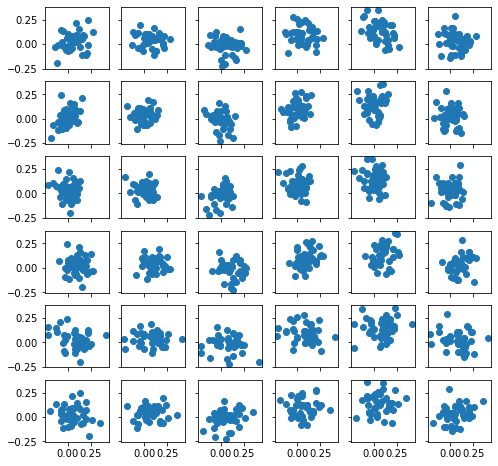

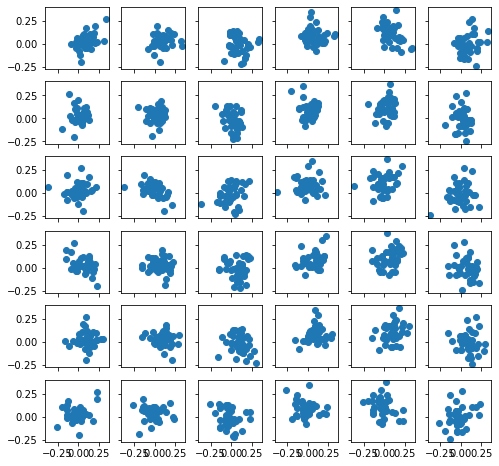

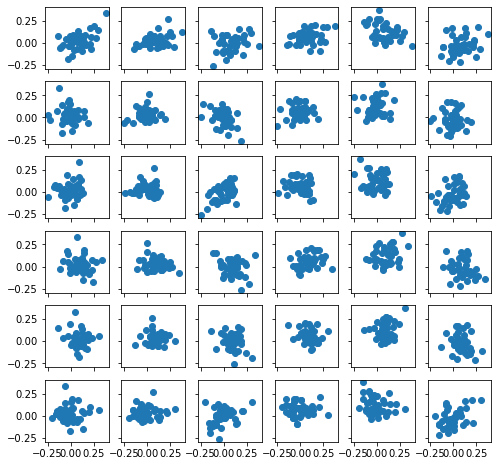

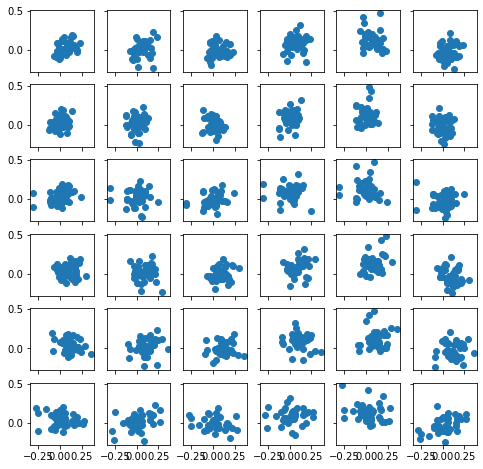

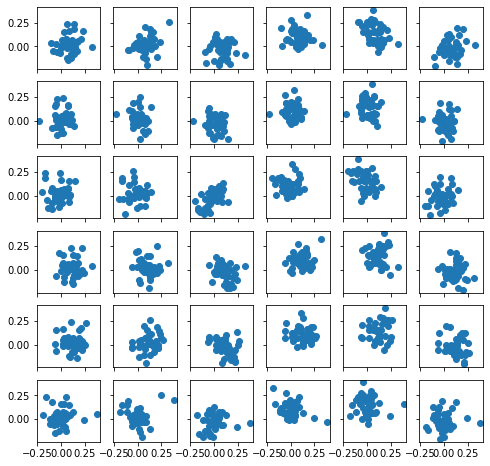

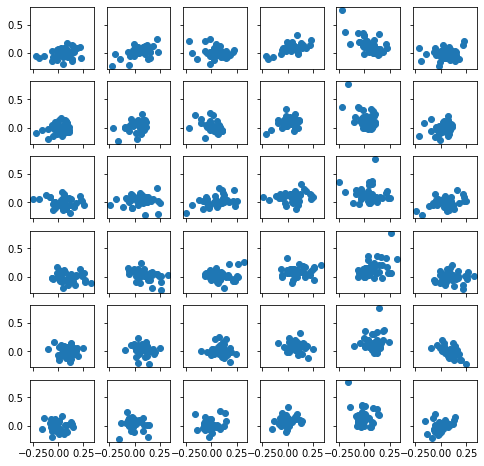

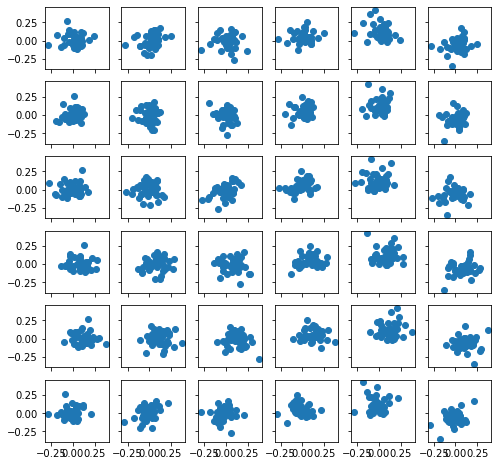

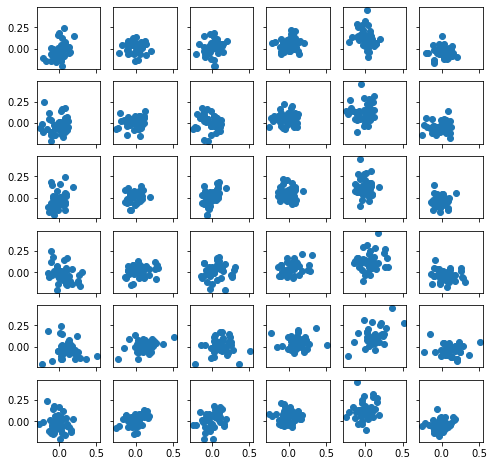

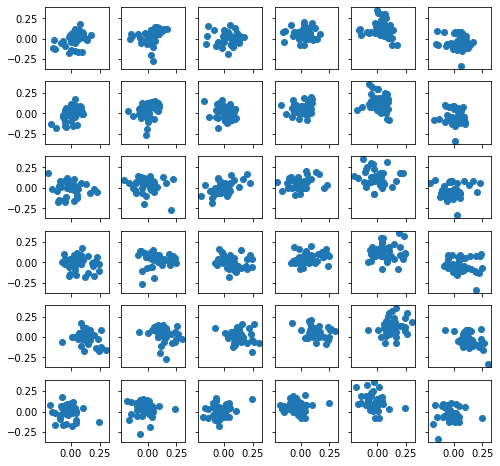

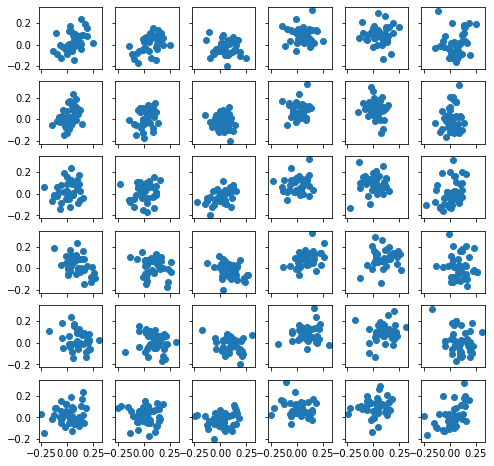

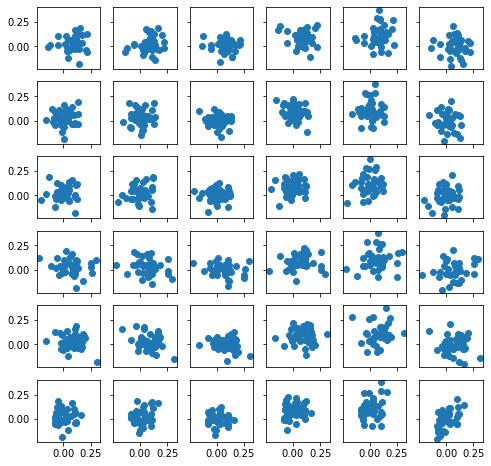

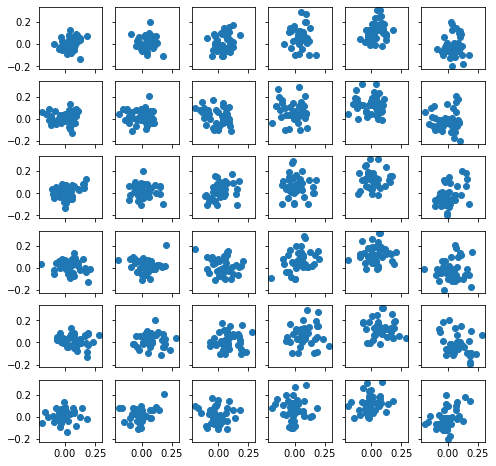

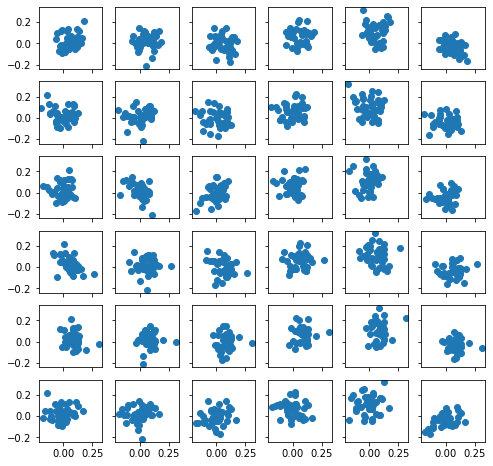

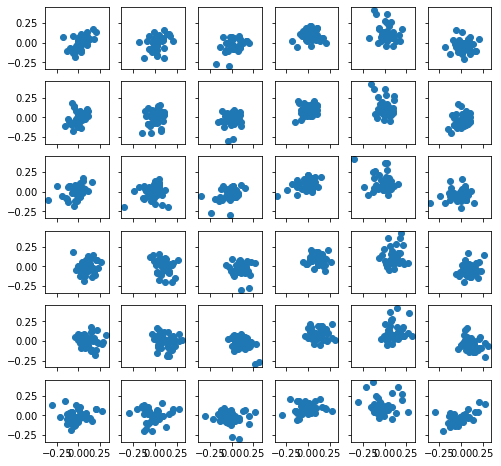

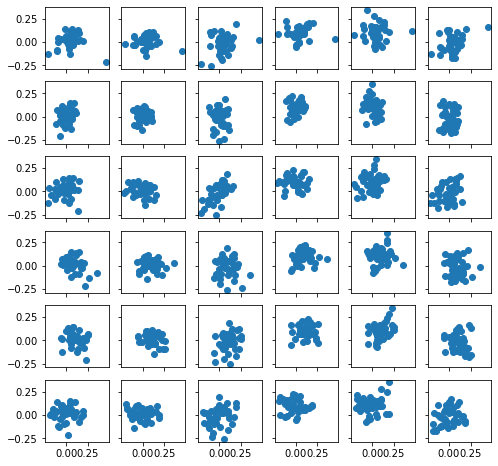

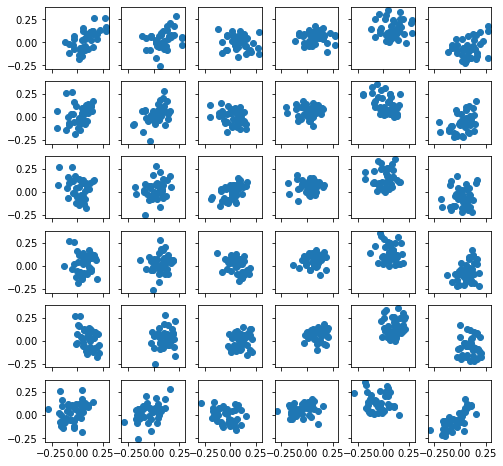

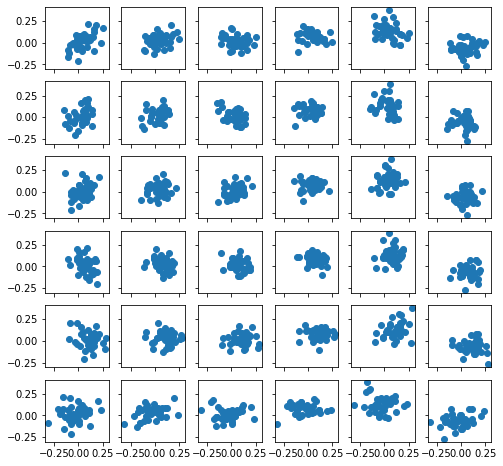

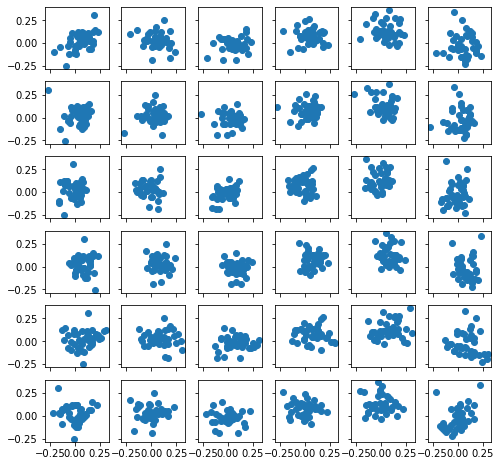

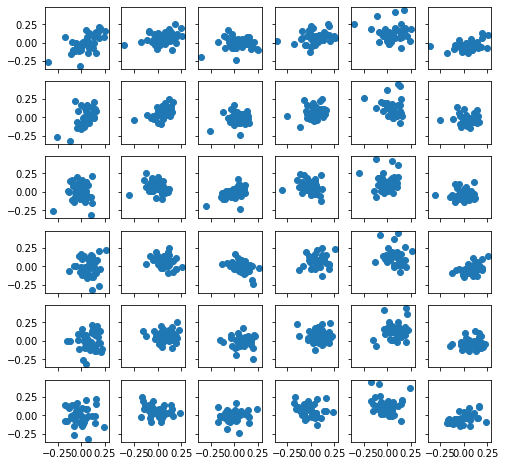

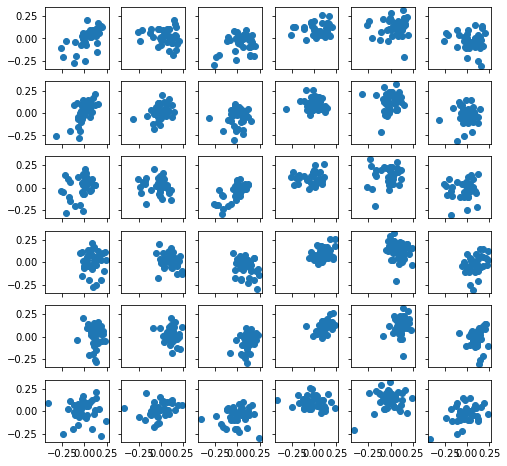

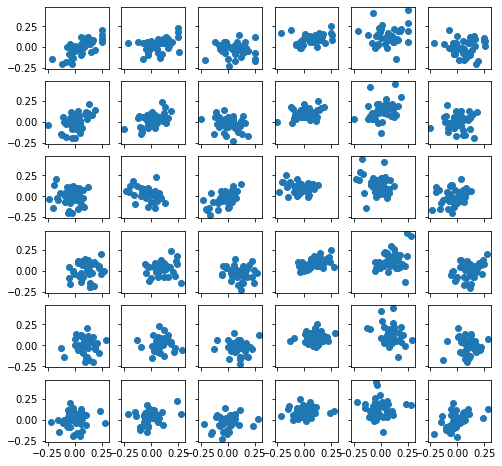

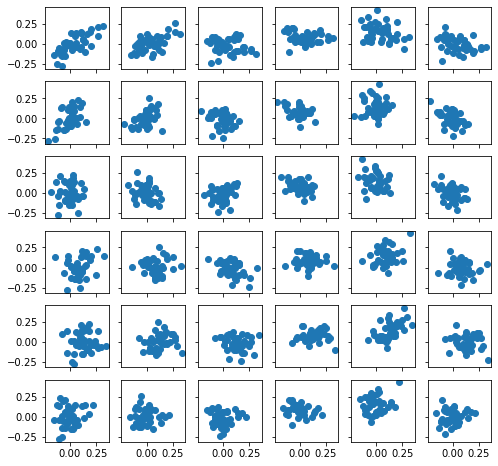

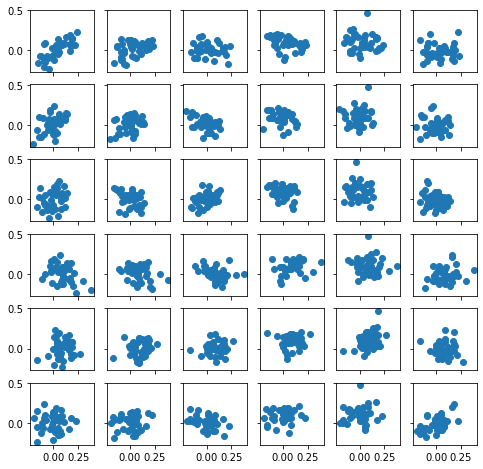

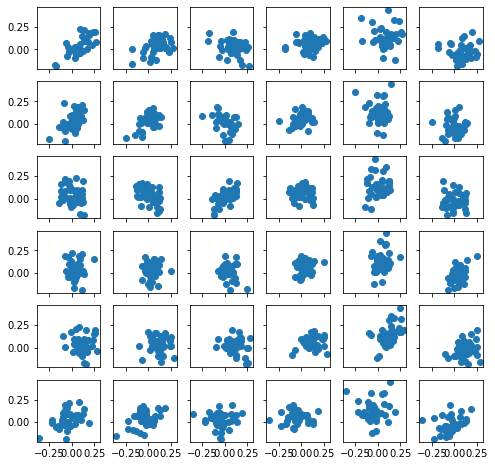

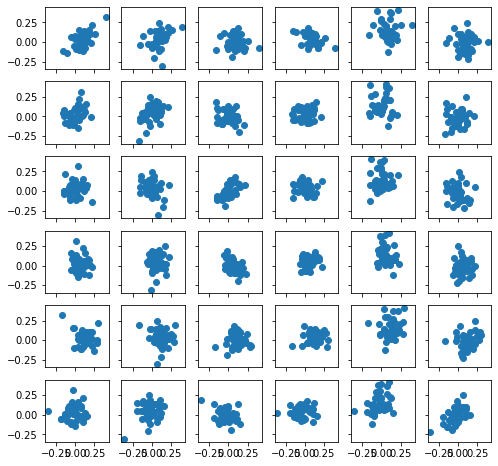

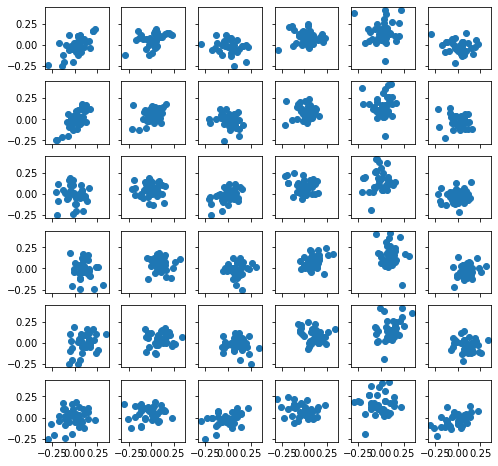

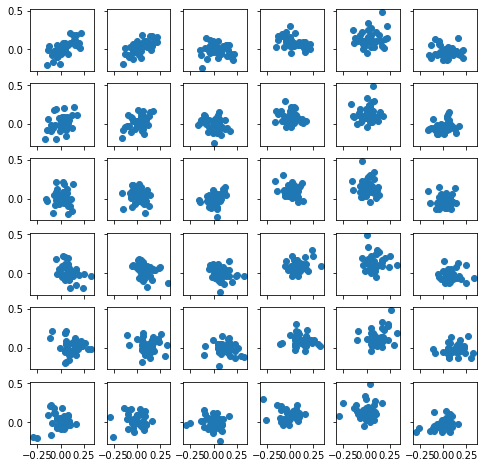

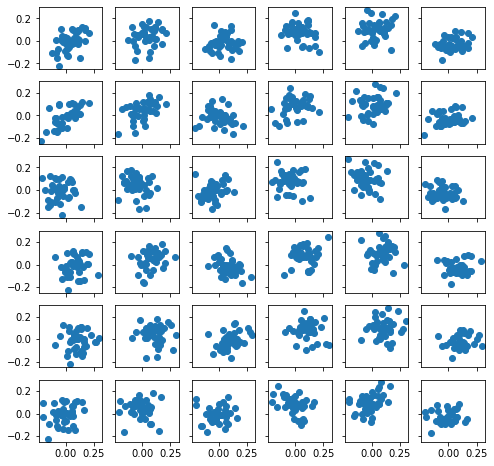

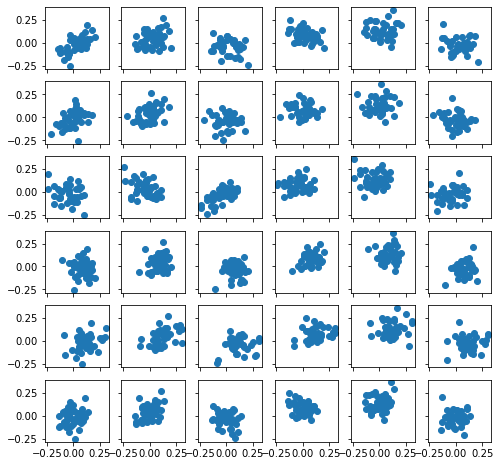

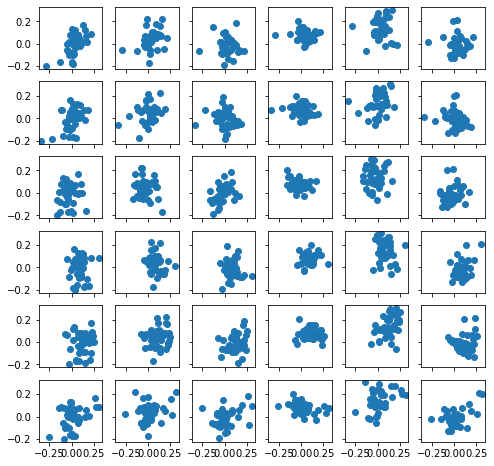

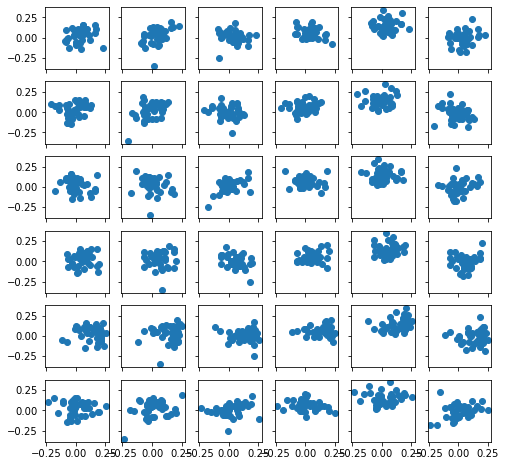

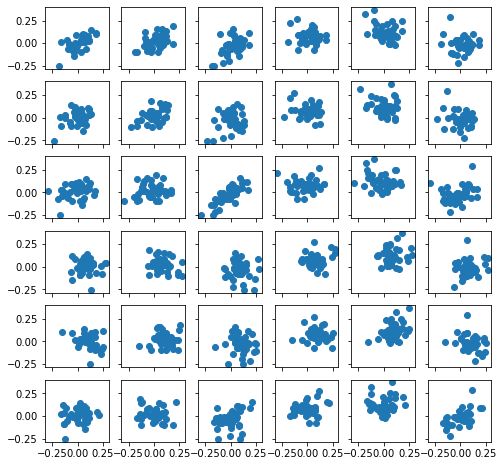

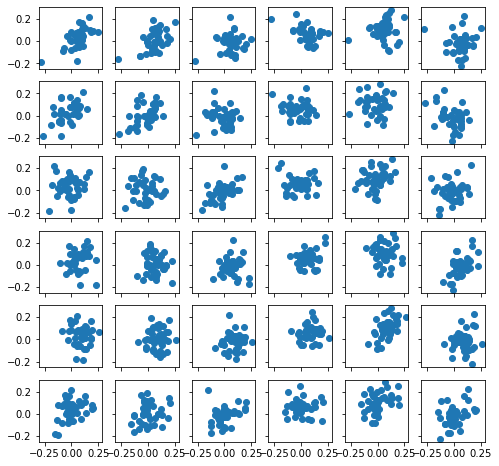

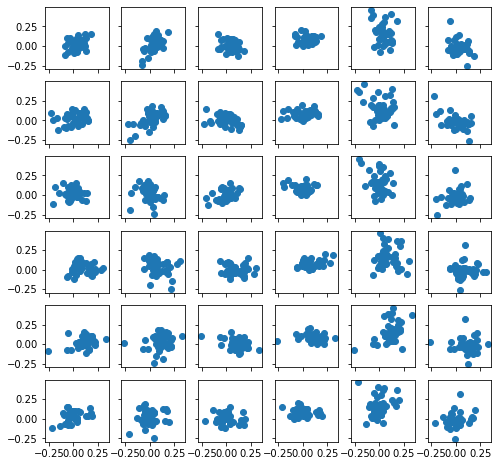

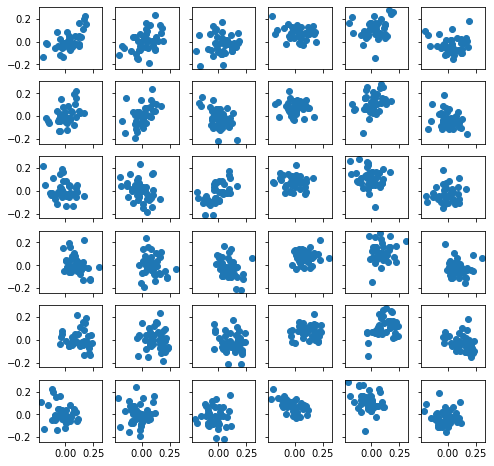

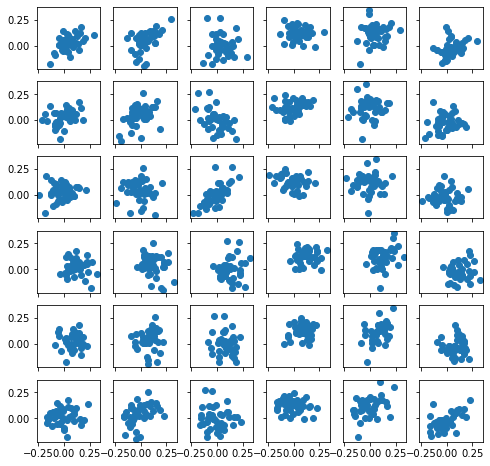

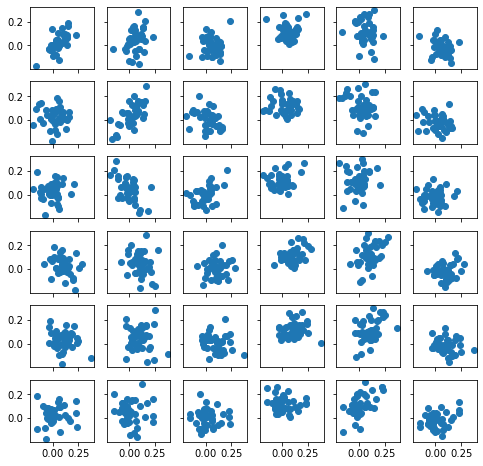

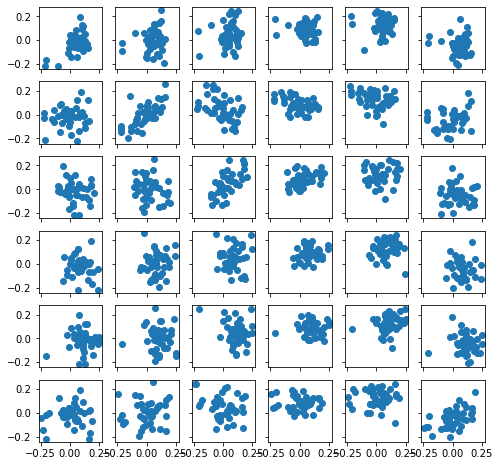

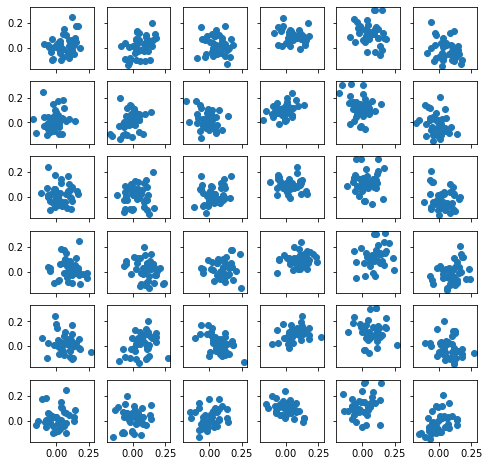

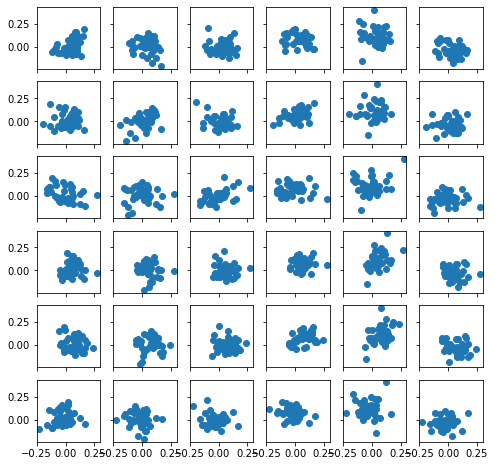

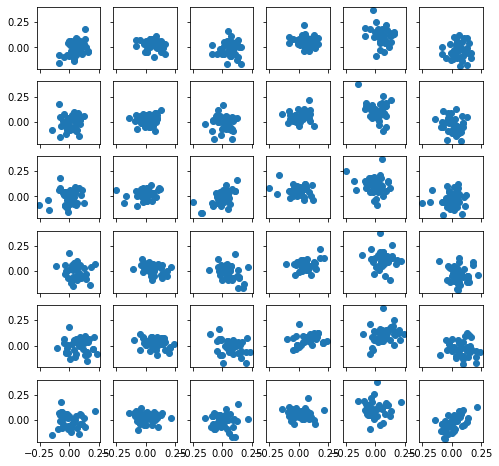

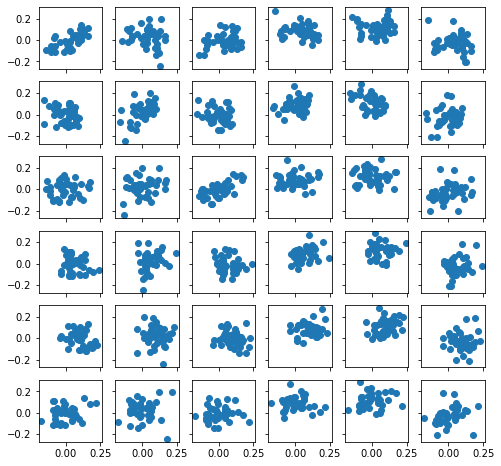

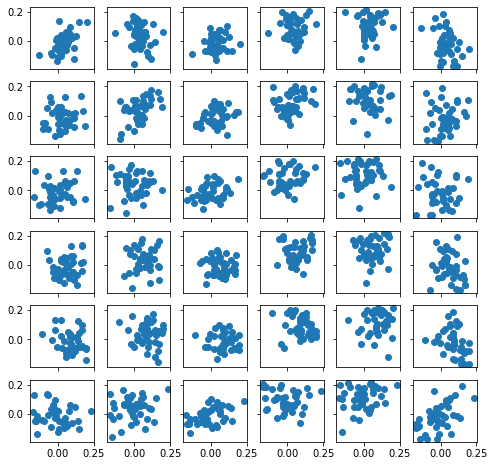

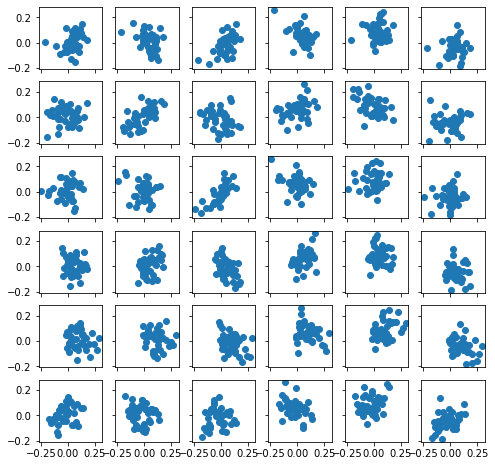

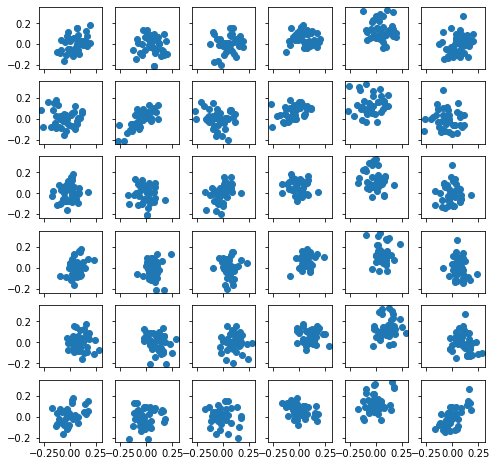

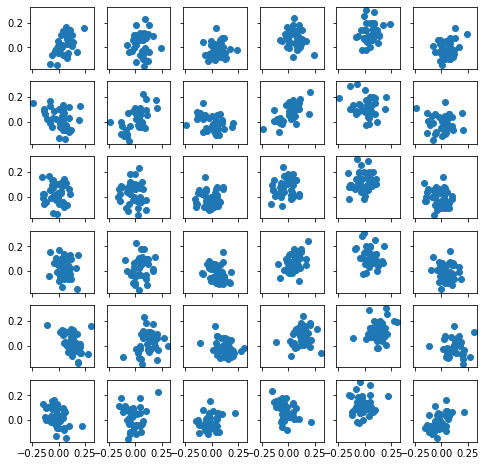

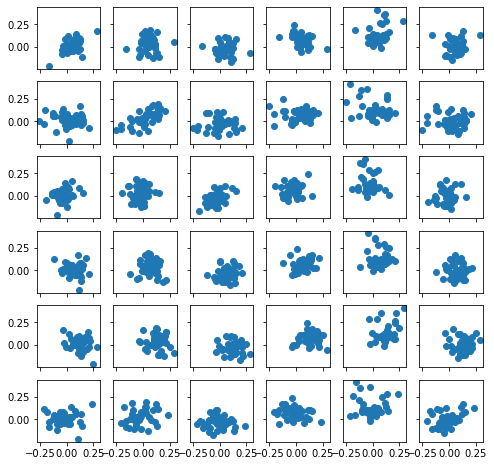

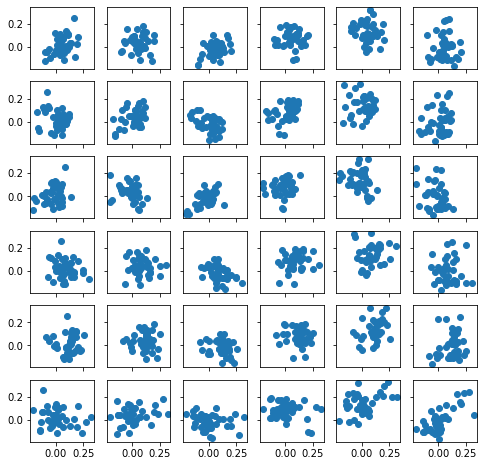

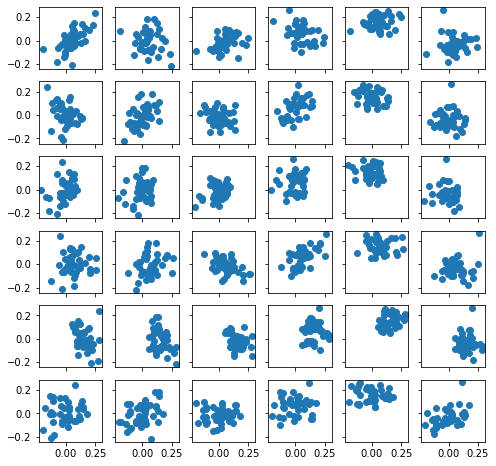

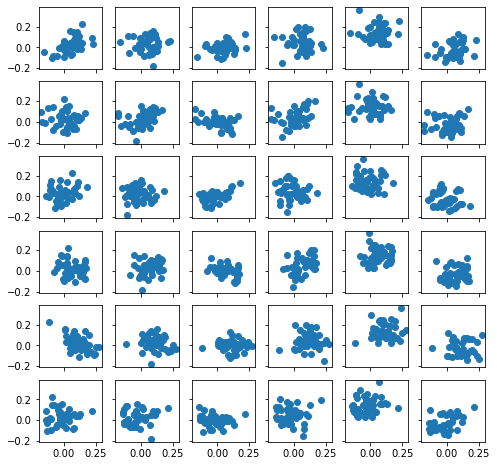

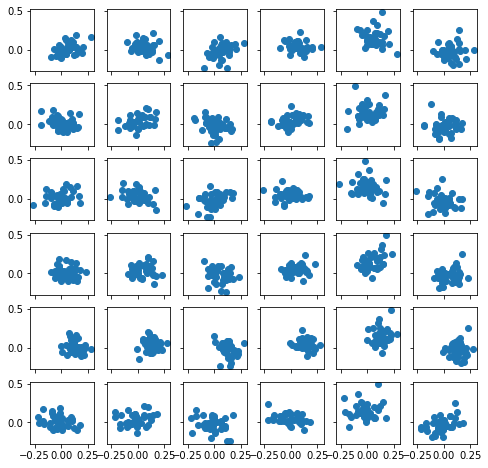

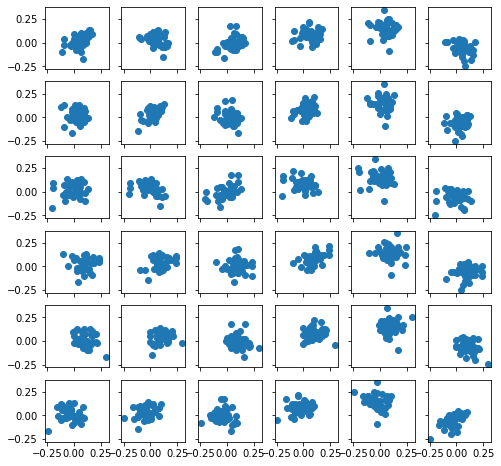

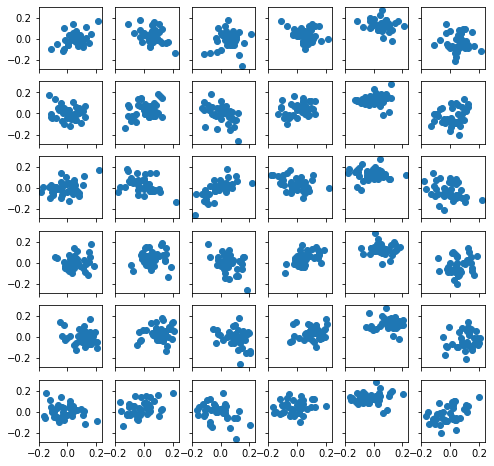

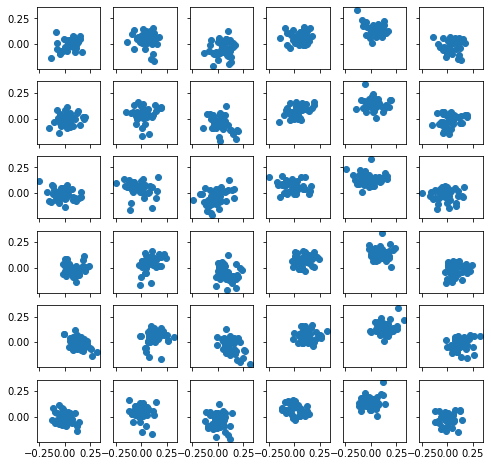

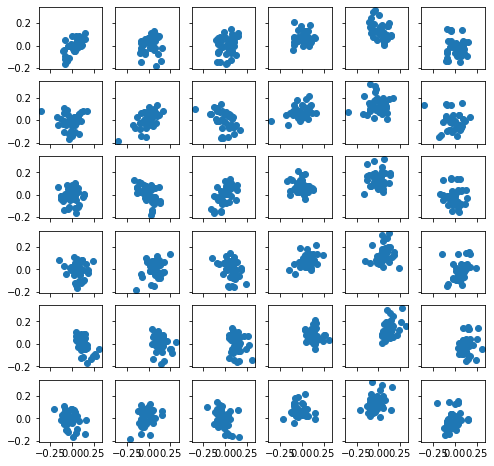

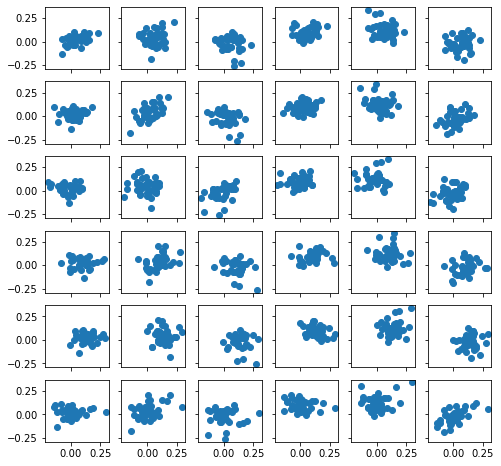

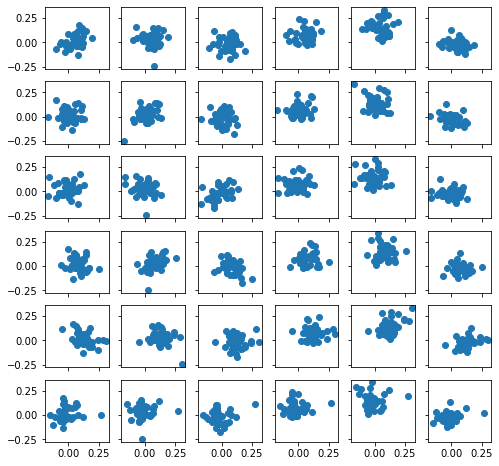

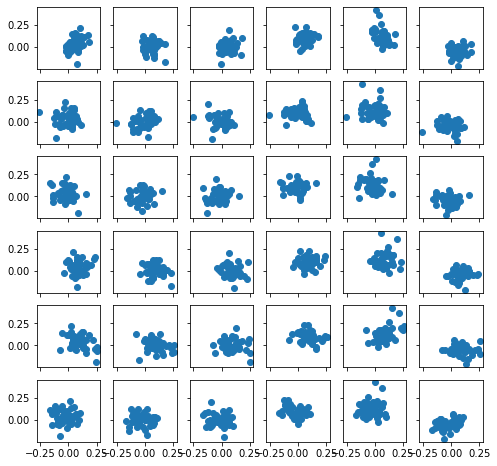

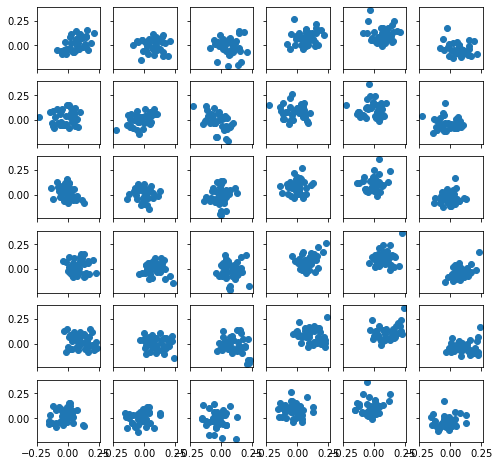

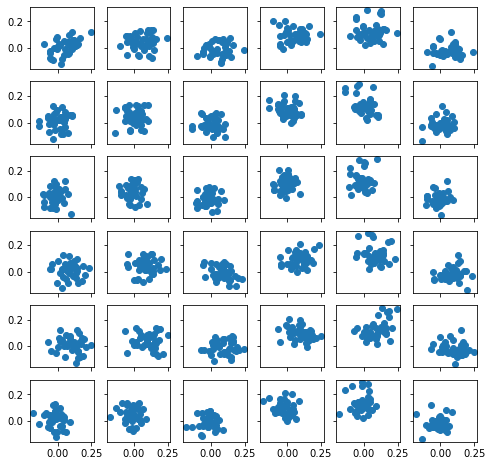

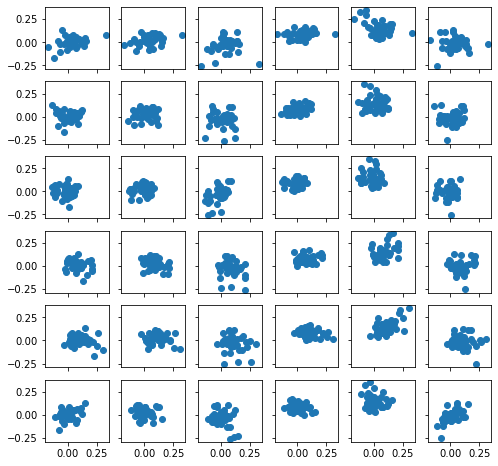

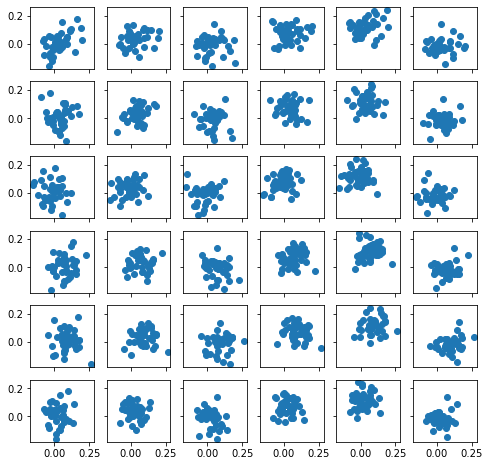

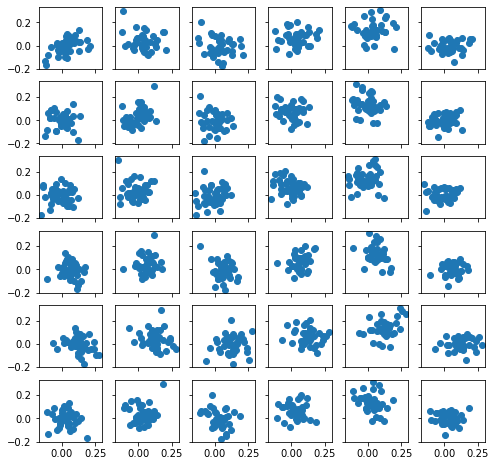

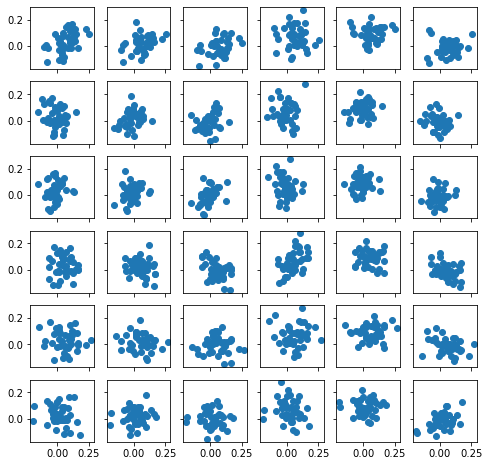

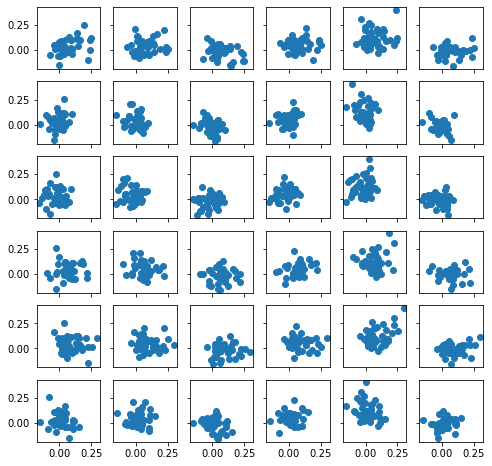

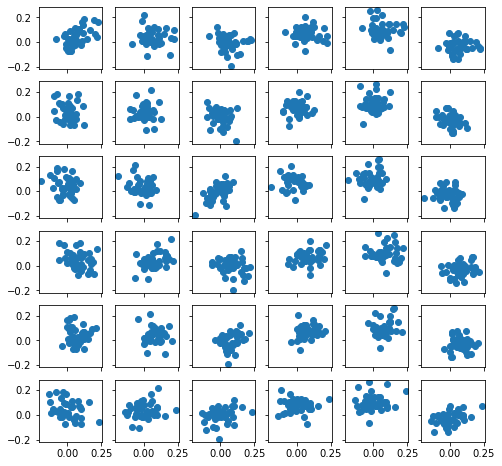

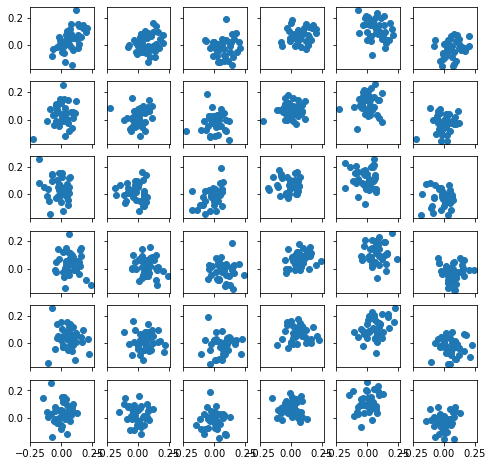

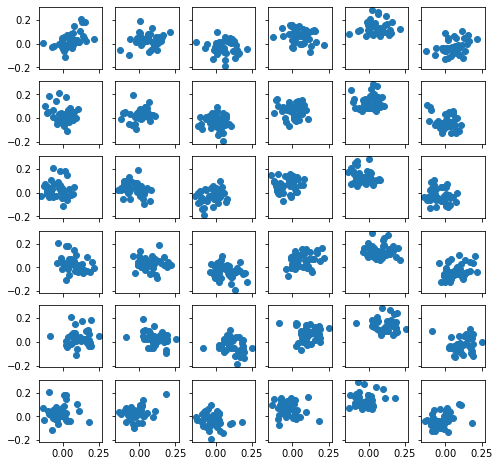

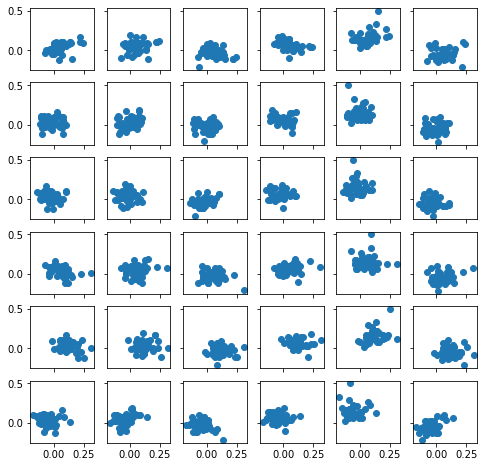

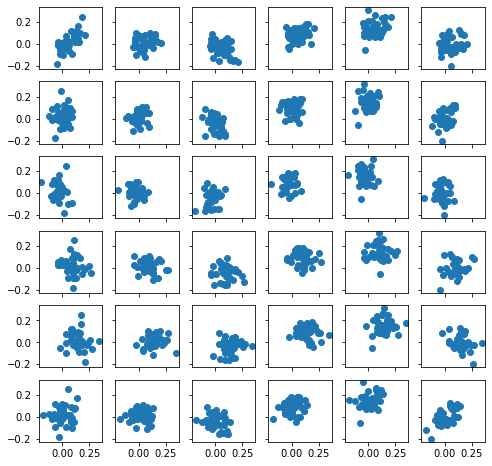

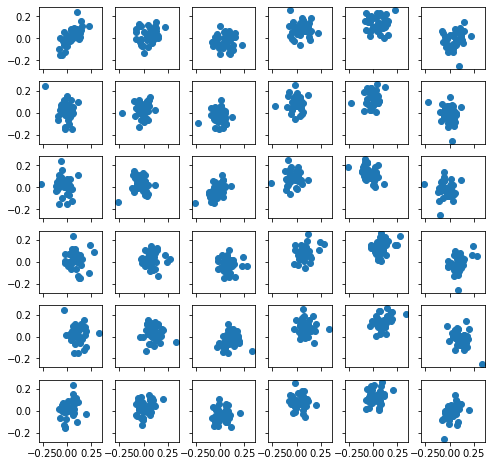

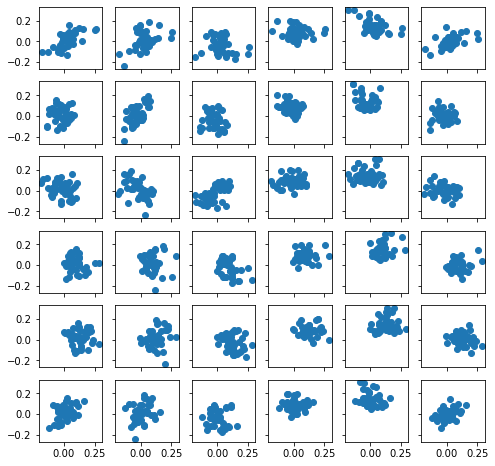

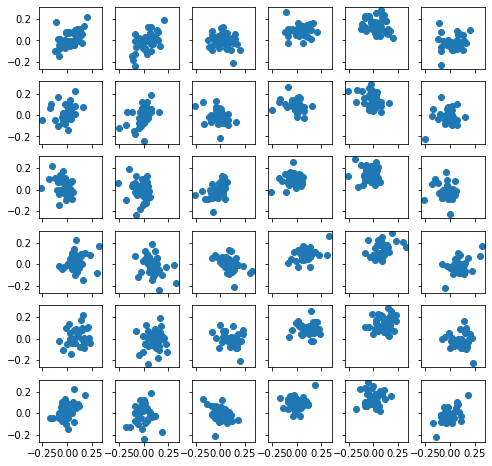

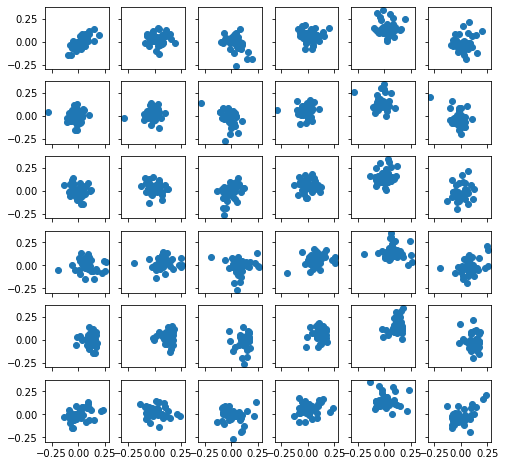

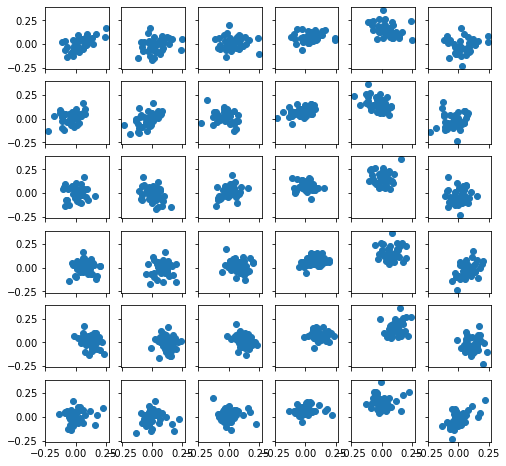

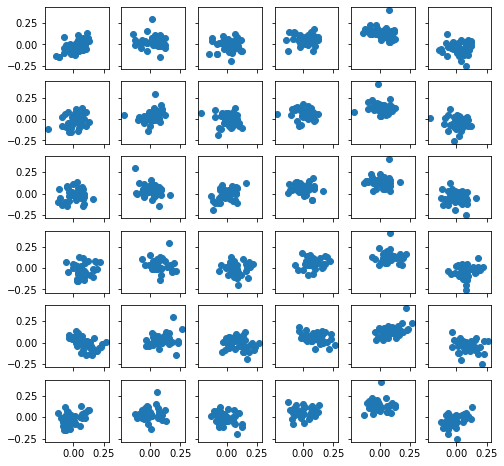

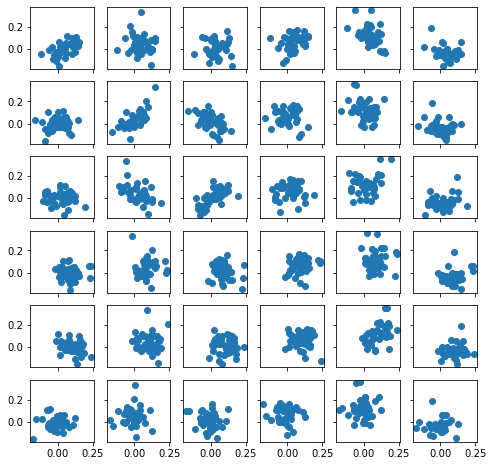

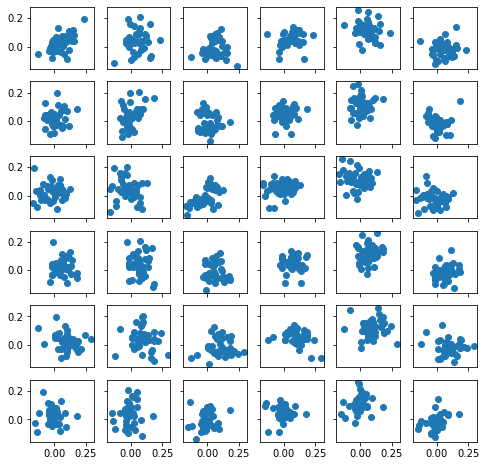

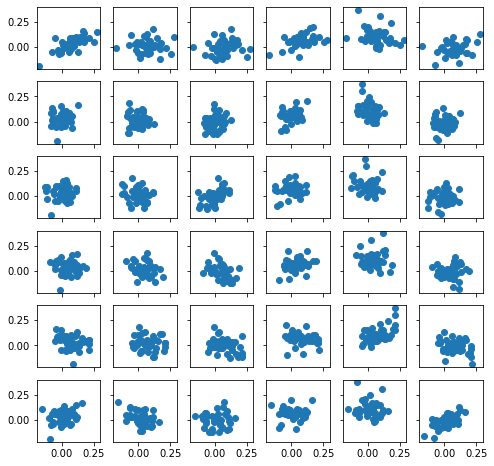

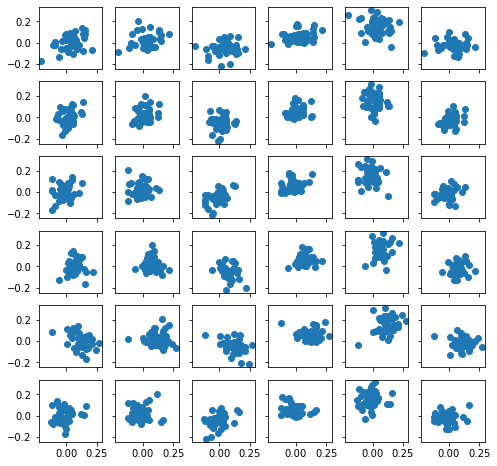

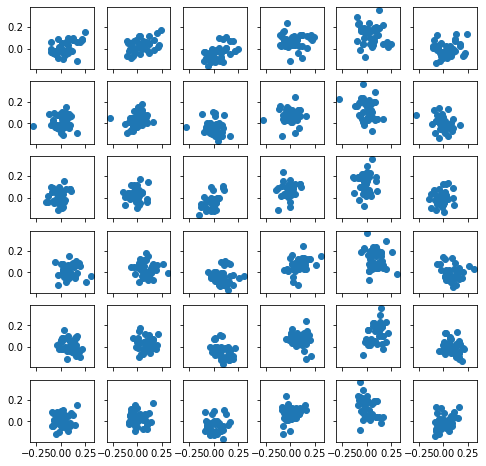

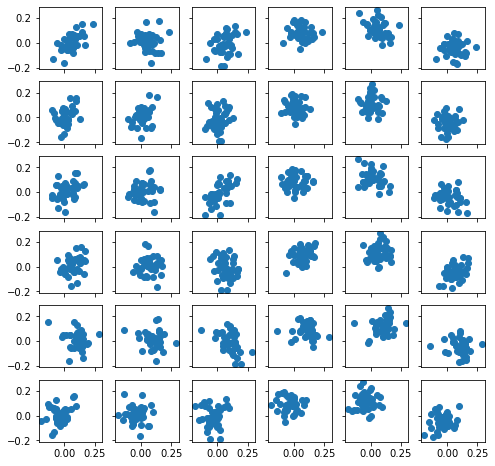

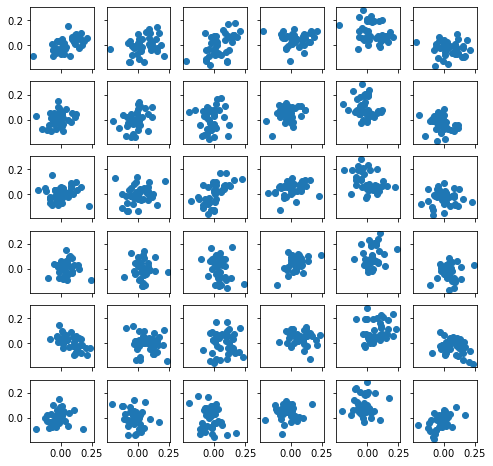

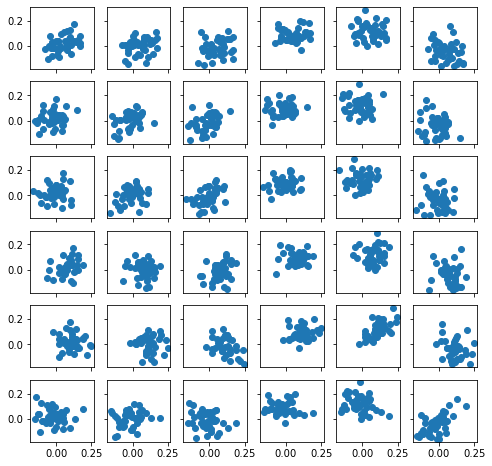

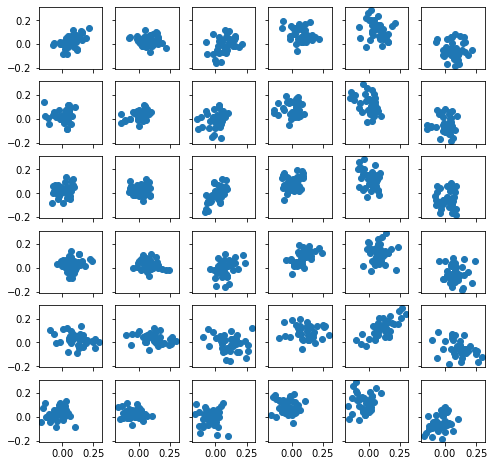

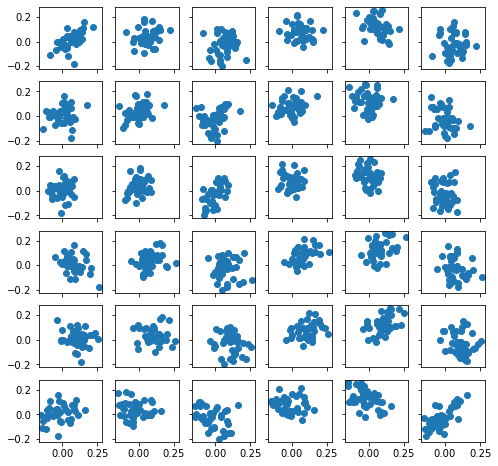

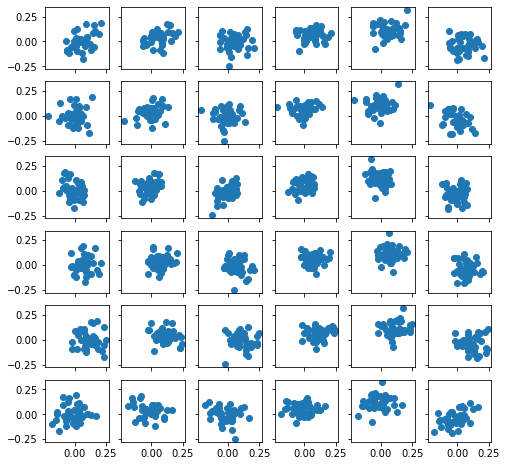

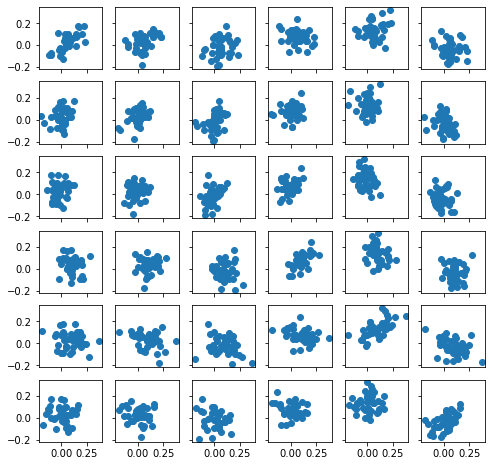

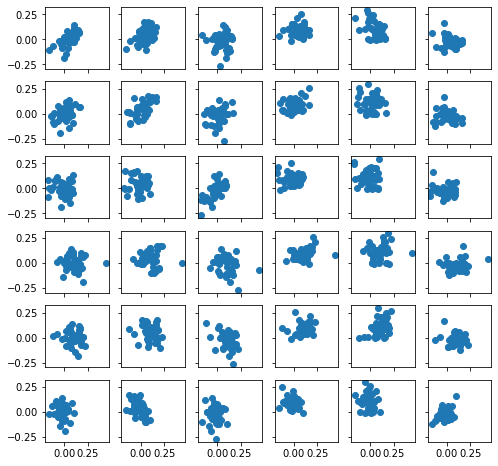

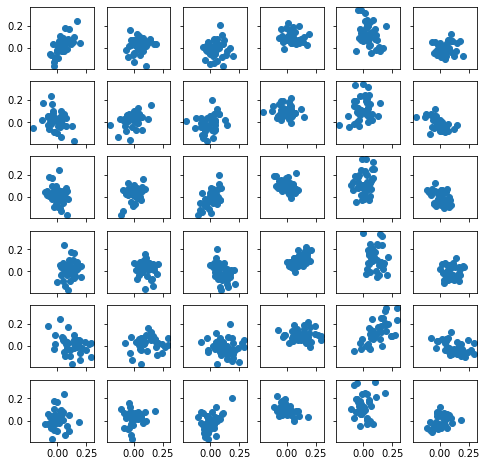

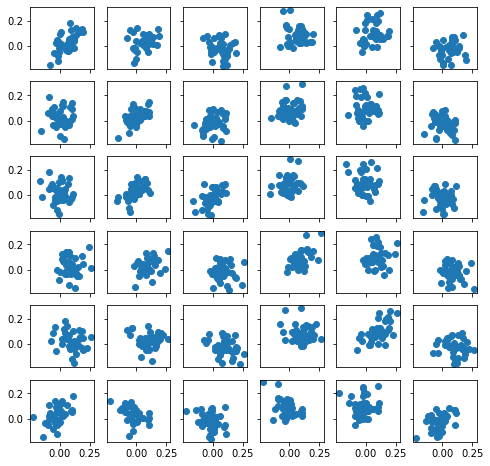

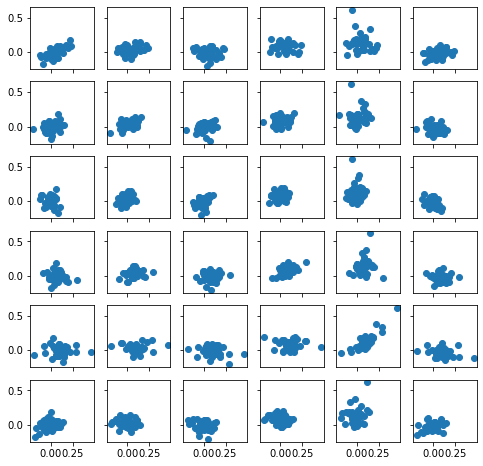

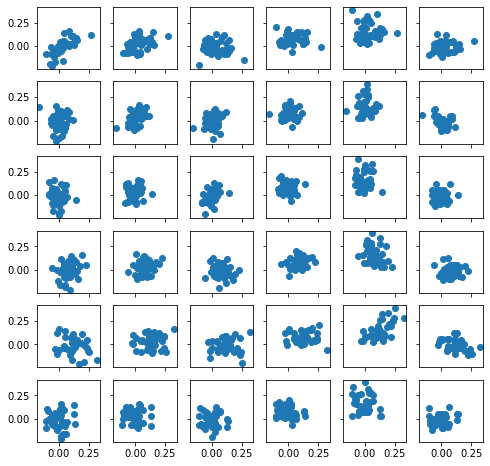

In [6]:
model = VAE(input_size=sample_dim*2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
torch.multiprocessing.set_start_method('spawn', force=True)
# Start training
for epoch in range(num_epochs):
    for i, x in enumerate(dataLoader):
        # Forward pass
        x = x.to(device).to(torch.float32)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        reconst_loss = F.mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = lamd*reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, (i+1)*batch_size, len(data), reconst_loss.item(), kl_div.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z)
        fig = plot_fig(out[:,:sample_dim].cpu(), out[:,sample_dim:].cpu(), d=6)
        plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
        # Save the reconstructed images
        out, _, _ = model(x)
        fig = plot_fig(out[:,:sample_dim].cpu(), out[:,sample_dim:].cpu(), d=6)
        plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))